In [1]:
import os
import re
import gc
import h5py
import torch
import string
import random
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from nltk import tokenize
from sklearn import preprocessing

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Rescaling
from keras import Input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from tensorflow.keras import Model

In [2]:
IMAGE_SIZE = (224, 224)
NUM_CHANNELS = 3

In [3]:
mvsa_single_path = '../input/mvsa-data/mvsa-single-4316.hdf5'
mvsa_multiple_path = '../input/mvsa-data/mvsa-multiple-16387.hdf5'

In [4]:
def clean_text(txt):
#     nonEnglish_regex = re.compile('[^a-zA-Z0-9\\?\\!\\,\\.@#\\+\\-=\\*\'\"><&\\$%\\(\\)\\[\\]:;]+')
#     hashtag_pattern = re.compile('#[a-zA-Z0-9]+')
#     txt_hashtag = re.sub(hashtag_pattern, '', txt)
    at_pattern = re.compile('@[a-zA-Z0-9]+')
    http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
    punc_pattern = re.compile('[%s]' % re.escape(string.punctuation))
    txt = re.sub(at_pattern, '<user>', txt)
    txt = re.sub(http_pattern, '<link>', txt)
    
    # as the data was crawled using Twitter API, it marked retweet data with RT <user> tag which has no meaning considering it in training
    if txt.startswith('RT <user>'):
        txt = ''.join(q.split(':')[1:])    
    txt = txt.strip()
    
    return txt

In [5]:
def get_clean_texts(data):
    cleaned_data = []
    for line in data:
        text = clean_text(line)
        cleaned_data.append(text)
    return cleaned_data

In [6]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

In [7]:
def load_mvsa_data(path, multiple=False):
    data = read_hdf5(path)
    for x in data:
        if x[0] == 'texts':
            texts = x[1]
        if x[0] == 'images':
            images = x[1]
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
            
    if multiple == True:
        images_path = os.path.join(os.path.split(path)[0], os.path.split(path)[1].split('.')[0] + '-images.npz')
#         npzfile = np.load(images_path)
#         images = npzfile['arr_0']
        images = loadz(images_path)
        
    return texts, images, labels, text_labels, image_labels

def loadz(path):
    data = np.load(path)['arr_0']
    return data

# Load raw data

In [8]:
mvsa_single_texts, mvsa_single_images, \
mvsa_single_multimodal_labels, mvsa_single_text_labels, \
mvsa_single_image_labels = load_mvsa_data(mvsa_single_path)
num_mvsa_single = len(mvsa_single_texts)

mvsa_multiple_texts, mvsa_multiple_images, \
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, \
mvsa_multiple_image_labels = load_mvsa_data(mvsa_multiple_path, multiple=True)
num_mvsa_multiple = len(mvsa_multiple_texts)

-----Sample-----
Text label: neutral
Image label: positive
Multimodal label: positive
Text: This #IT #job might be a great fit for you: Project Manager - #Montreal, QC #Hiring http://t.co/1Dzdz8n7pD
Image:


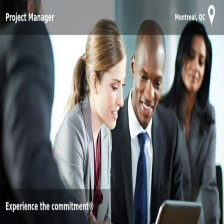

In [9]:
SAMPLE = random.choice(range(num_mvsa_multiple))
print('-----Sample-----')
print('Text label:', mvsa_multiple_text_labels[SAMPLE])
print('Image label:', mvsa_multiple_image_labels[SAMPLE])
print('Multimodal label:', mvsa_multiple_multimodal_labels[SAMPLE])
print('Text:', mvsa_multiple_texts[SAMPLE])
print('Image:')
tf.keras.utils.array_to_img(mvsa_multiple_images[SAMPLE])

# VGG-16

In [10]:
vgg16 = VGG16(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
vgg16.trainable = False # Freeze pre-trained layers
vgg16_last = Model(inputs=vgg16.input, outputs=vgg16.layers[-2].output) # output of last hidden layer
vgg16_last.summary()

2022-06-29 13:21:36.197474: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


553476096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [11]:
image_inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
rescale_layer = Rescaling(scale=1./255.) (image_inputs)  # Rescale inputs
outputs = vgg16_last (rescale_layer)
model_vgg16 = Model(inputs=image_inputs, outputs=outputs)#vgg16.layers[-2].output)
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
model (Functional)           (None, 4096)              134260544 
Total params: 134,260,544
Trainable params: 0
Non-trainable params: 134,260,544
_________________________________________________________________


In [12]:
print('MVSA-Single: Extracting VGG-16 features of images')
mvsa_single_vgg16 = model_vgg16.predict(mvsa_single_images, verbose=1)
print('VGG-16 last hidden layer dimension:', mvsa_single_vgg16.shape[1])
print('MVSA-Single with VGG-16 last hidden layer:', mvsa_single_vgg16.shape)

# save and load check
np.savez('./mvsa-single-vgg16', mvsa_single_vgg16)
x = loadz('./mvsa-single-vgg16.npz')
print((x == mvsa_single_vgg16).all())

MVSA-Single: Extracting VGG-16 features of images


2022-06-29 13:21:44.133356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


135/135 [==============================] - 1070s 8s/step
VGG-16 last hidden layer dimension: 4096
MVSA-Single with VGG-16 last hidden layer: (4316, 4096)
True


In [13]:
print('MVSA-Multiple: Extracting VGG-16 features of images')
mvsa_multiple_vgg16 = model_vgg16.predict(mvsa_multiple_images, verbose=1)
print('VGG-16 last hidden layer dimension:', mvsa_multiple_vgg16.shape[1])
print('MVSA-Multiple with VGG-16 last hidden layer:', mvsa_multiple_vgg16.shape)

# save and load check
np.savez('./mvsa-multiple-vgg16', mvsa_multiple_vgg16)
x = loadz('./mvsa-multiple-vgg16.npz')
print((x == mvsa_multiple_vgg16).all())

MVSA-Multiple: Extracting VGG-16 features of images
513/513 [==============================] - 4118s 8s/step
VGG-16 last hidden layer dimension: 4096
MVSA-Multiple with VGG-16 last hidden layer: (16387, 4096)
True
